In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics.cluster import silhouette_score
import pickle
import catboost as cbt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score
from catboost.utils import get_gpu_device_count
import seaborn as sns

# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', 20)
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

c:\users\eugene\appdata\local\programs\python\python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Загружаем и подготавливаем набор данных для обучения

In [2]:
train_df = pd.read_csv('train_preprocessed.csv', keep_default_na=False)
train_df

,TENURE,CITY,is_churn,BILLS_NUM,INV_MON_1,INV_MON_2,INV_MON_3,INV_MON_4,INV_MON_5,INV_MON_6,N_LATE_FEES,N_NON_SETTLED,AVG_BILL,MIN_BILL,MAX_BILL,MAX2MIN_BILL,PAY_NUM,AVG_PAY,MAX_PAY,MIN_PAY,PAY_MON_1,PAY_MON_2,PAY_MON_3,PAY_MON_4,PAY_MON_5,PAY_MON_6,MAX2MIN_PAY,ADJ_NUM,AVG_ADJ,ADJ_MON_1,ADJ_MON_2,ADJ_MON_3,ADJ_MON_4,ADJ_MON_5,ADJ_MON_6,MIN_ADJ,MAX_ADJ,MAXMINDIFF_ADJ,DSON_NUM_BUNDLE,DSON_MON_1_BUNDLE,DSON_MON_2_BUNDLE,DSON_MON_3_BUNDLE,DSON_MON_4_BUNDLE,DSON_MON_5_BUNDLE,DSON_MON_6_BUNDLE,DSON_NUM_PROMO,DSON_MON_1_PROMO,DSON_MON_2_PROMO,DSON_MON_3_PROMO,DSON_MON_4_PROMO,DSON_MON_5_PROMO,DSON_MON_6_PROMO,DSOF_NUM_BUNDLE,DSOF_MON_1_BUNDLE,DSOF_MON_2_BUNDLE,DSOF_MON_3_BUNDLE,DSOF_MON_4_BUNDLE,DSOF_MON_5_BUNDLE,DSOF_MON_6_BUNDLE,DSOF_NUM_PROMO,DSOF_MON_1_PROMO,DSOF_MON_2_PROMO,DSOF_MON_3_PROMO,DSOF_MON_4_PROMO,DSOF_MON_5_PROMO,DSOF_MON_6_PROMO,INTERACTS_NUM,TFT,SUPPORT,SOCIAL_MEDIA,OUTBOUND_CALL,MANAGE_ACCT,INQUIRY,INBOUND_CALL,ESCALATION,EMAIL,CALL_BACK,CTI,PLAY_TV,PLAY_PHONE,PLAY_INET,SINGLE_PLAY,DOUBLE_PLAY,TRIPLE_PLAY,UNKNOWN_PLAY,INV_MON_A,INV_MON_B,PAY_MON_A,PAY_MON_B,ADJ_MON_A,ADJ_MON_B,DSON_MONPROMO_A,DSON_MONPROMO_B,DSOF_MONPROMO_A,DSOF_MONPROMO_B,DSON_MONBUNDLE_A,DSON_MONBUNDLE_B,DSOF_MONBUNDLE_A,DSOF_MONBUNDLE_B,ITR_CAT_119,ITR_CAT_120,ITR_CAT_114,ITR_CAT_9,ITR_CAT_123,ITR_CAT_128,ITR_CAT_102,ITR_CAT_104,ITR_CAT_115,ITR_CAT_8,ITR_CAT_122,ITR_CAT_0,ITR_CAT_22,ITR_CAT_133,ITR_CAT_124,ITR_CAT_135,ITR_CAT_56,ITR_CAT_113,ITR_CAT_126,ITR_CAT_116,ITR_CAT_84,ITR_CAT_51,ITR_CAT_117,ITR_CAT_105,ITR_CAT_81,ITR_CAT_54,ITR_CAT_101,ITR_CAT_134,ITR_CAT_71,ITR_CAT_62,ITR_CAT_78,ITR_CAT_138,ITR_CAT_17,ITR_CAT_41,ITR_CAT_69,ADJ_TYP_BALANCE_TRANSFER,ADJ_TYP_CREDIT_UNRETURNED_EQUI,ADJ_TYP_TELEVISION_PRODUCT,ADJ_TYP_OTHERS,ADJ_TYP_COLLECTION_CHARGES,ADJ_TYP_GOODWILL_CREDIT,ADJ_TYP_EQUIPMENT,ADJ_TYP_INTERNET_USAGE,ADJ_TYP_INSTALLATION_FEES,ADJ_TYP_PHONE_PRODUCT,ADJ_TYP_TELEPHONY_USAGE,ADJ_TYP_EARLY_TERMINATION_FEES,ADJ_TYP_VIDEO_ON_DEMAND,ADJ_TYP_OTHER_PAYMENTS,ADJ_TYP_RECOVERY_OF_CREDIT_WRI,ADJ_TYP_LATE_FEES,ADJ_TYP_ADMIN_FEES,ADJ_TYP_OTHER_FEES,ADJ_TYP_INTERNET_PRODUCT,ADJ_TYP_ACTIVATION_FEES,ADJ_TYP_REFUSED_BY_PAYOR_OTHER,ADJ_TYP_RATE_CHANGE,ADJ_TYP_CREDIT_BALANCE,ADJ_TYP_PAYMENT_DEBIT_AUTHORIZ,ADJ_TYP_PAY_PER_VIEW,ADJ_TYP_RECONNECT_FEES,PAYMENT_METHOD,AGE,LANGUAGE,GENDER,REGION,PRODUCT_NAME=0,PRODUCT_NAME=1,PRODUCT_NAME=2,PRODUCT_NAME=3,PRODUCT_NAME=4,PRODUCT_NAME=5,PRODUCT_NAME=6,PRODUCT_NAME=7,PRODUCT_NAME=8,PRODUCT_NAME=9,PRODUCT_NAME=10,PRODUCT_NAME=11,PRODUCT_NAME=12,PRODUCT_NAME=13,PRODUCT_NAME=14,PRODUCT_NAME=15,PRODUCT_NAME=16,PRODUCT_NAME=17,PRODUCT_NAME=18,PRODUCT_NAME=19,PRODUCT_NAME=20,PRODUCT_NAME=21,PRODUCT_NAME=22,PRODUCT_NAME=23,PRODUCT_NAME=24,PRODUCT_NAME=25,PRODUCT_NAME=26,PRODUCT_NAME=27,PRODUCT_NAME=28,PRODUCT_NAME=29,PRODUCT_NAME=30,PRODUCT_NAME=31,PRODUCT_NAME=32,PRODUCT_NAME=33,PRODUCT_NAME=34,PRODUCT_NAME=35,PRODUCT_NAME=36,PRODUCT_NAME=37,PRODUCT_NAME=38,PRODUCT_NAME=39,PRODUCT_NAME=40,PRODUCT_NAME=41,PRODUCT_NAME=42,PRODUCT_NAME=43,PRODUCT_NAME=44,PRODUCT_NAME=45,PRODUCT_NAME=46,PRODUCT_NAME=47,PRODUCT_NAME=48,PRODUCT_NAME=49,PRODUCT_NAME=50,PRODUCT_NAME=51,PRODUCT_NAME=52,PRODUCT_NAME=53,PRODUCT_NAME=54,PRODUCT_NAME=55,PRODUCT_NAME=56,PRODUCT_NAME=57,PRODUCT_NAME=58,PRODUCT_NAME=59,PRODUCT_NAME=60,PRODUCT_NAME=61,PRODUCT_NAME=62,PRODUCT_NAME=63,PRODUCT_NAME=64,PRODUCT_NAME=65,PRODUCT_NAME=66,PRODUCT_NAME=67,PRODUCT_NAME=68,PRODUCT_NAME=69,PRODUCT_NAME=70,PRODUCT_NAME=71,PRODUCT_NAME=72,PRODUCT_NAME=73,PRODUCT_NAME=74,PRODUCT_NAME=75,PRODUCT_NAME=76,PRODUCT_NAME=77,PRODUCT_NAME=78,PRODUCT_NAME=79,PRODUCT_NAME=80,PRODUCT_NAME=81,PRODUCT_NAME=82,PRODUCT_NAME=83,PRODUCT_NAME=84,PRODUCT_NAME=85,PRODUCT_NAME=86,PRODUCT_NAME=87,PRODUCT_NAME=88,PRODUCT_NAME=89,PRODUCT_NAME=90,PRODUCT_NAME=91,PRODUCT_NAME=92,PRODUCT_NAME=93,PRODUCT_NAME=94,PRODUCT_NAME=95,PRODUCT_NAME=96,PRODUCT_NAME=97,PRODUCT_NAME=98,PRODUCT_NAME=99,PRODUCT_NAME=100,PRODUCT_NAME=101,PRODUCT_NAME=102,PRODUCT_NAME=103,PRODUCT_NAME=104,PRODUCT_NAME=105,P

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589878 entries, 0 to 589877
Columns: 505 entries, TENURE to PRODUCT_NAME=339
dtypes: float64(39), int64(123), object(343)
memory usage: 2.2+ GB


In [4]:
train_df.describe()

,TENURE,CITY,is_churn,BILLS_NUM,INV_MON_1,INV_MON_2,INV_MON_3,INV_MON_4,INV_MON_5,INV_MON_6,N_LATE_FEES,N_NON_SETTLED,AVG_BILL,MIN_BILL,MAX_BILL,MAX2MIN_BILL,PAY_NUM,AVG_PAY,MAX_PAY,MIN_PAY,PAY_MON_1,PAY_MON_2,PAY_MON_3,PAY_MON_4,PAY_MON_5,PAY_MON_6,MAX2MIN_PAY,ADJ_NUM,AVG_ADJ,ADJ_MON_1,ADJ_MON_2,ADJ_MON_3,ADJ_MON_4,ADJ_MON_5,ADJ_MON_6,MIN_ADJ,MAX_ADJ,MAXMINDIFF_ADJ,DSON_NUM_BUNDLE,DSON_MON_1_BUNDLE,DSON_MON_2_BUNDLE,DSON_MON_3_BUNDLE,DSON_MON_4_BUNDLE,DSON_MON_5_BUNDLE,DSON_MON_6_BUNDLE,DSON_NUM_PROMO,DSON_MON_1_PROMO,DSON_MON_2_PROMO,DSON_MON_3_PROMO,DSON_MON_4_PROMO,DSON_MON_5_PROMO,DSON_MON_6_PROMO,DSOF_NUM_BUNDLE,DSOF_MON_1_BUNDLE,DSOF_MON_2_BUNDLE,DSOF_MON_3_BUNDLE,DSOF_MON_4_BUNDLE,DSOF_MON_5_BUNDLE,DSOF_MON_6_BUNDLE,DSOF_NUM_PROMO,DSOF_MON_1_PROMO,DSOF_MON_2_PROMO,DSOF_MON_3_PROMO,DSOF_MON_4_PROMO,DSOF_MON_5_PROMO,DSOF_MON_6_PROMO,INTERACTS_NUM,TFT,SUPPORT,SOCIAL_MEDIA,OUTBOUND_CALL,MANAGE_ACCT,INQUIRY,INBOUND_CALL,ESCALATION,EMAIL,CALL_BACK,CTI,PLAY_TV,PLAY_PHONE,PLAY_INET,SINGLE_PLAY,DOUBLE_PLAY,TRIPLE_PLAY,UNKNOWN_PLAY,INV_MON_A,INV_MON_B,PAY_MON_A,PAY_MON_B,ADJ_MON_A,ADJ_MON_B,DSON_MONPROMO_A,DSON_MONPROMO_B,DSOF_MONPROMO_A,DSOF_MONPROMO_B,DSON_MONBUNDLE_A,DSON_MONBUNDLE_B,DSOF_MONBUNDLE_A,DSOF_MONBUNDLE_B,ITR_CAT_119,ITR_CAT_120,ITR_CAT_114,ITR_CAT_9,ITR_CAT_123,ITR_CAT_128,ITR_CAT_102,ITR_CAT_104,ITR_CAT_115,ITR_CAT_8,ITR_CAT_122,ITR_CAT_0,ITR_CAT_22,ITR_CAT_133,ITR_CAT_124,ITR_CAT_135,ITR_CAT_56,ITR_CAT_113,ITR_CAT_126,ITR_CAT_116,ITR_CAT_84,ITR_CAT_51,ITR_CAT_117,ITR_CAT_105,ITR_CAT_81,ITR_CAT_54,ITR_CAT_101,ITR_CAT_134,ITR_CAT_71,ITR_CAT_62,ITR_CAT_78,ITR_CAT_138,ITR_CAT_17,ITR_CAT_41,ITR_CAT_69,ADJ_TYP_BALANCE_TRANSFER,ADJ_TYP_CREDIT_UNRETURNED_EQUI,ADJ_TYP_TELEVISION_PRODUCT,ADJ_TYP_OTHERS,ADJ_TYP_COLLECTION_CHARGES,ADJ_TYP_GOODWILL_CREDIT,ADJ_TYP_EQUIPMENT,ADJ_TYP_INTERNET_USAGE,ADJ_TYP_INSTALLATION_FEES,ADJ_TYP_PHONE_PRODUCT,ADJ_TYP_TELEPHONY_USAGE,ADJ_TYP_EARLY_TERMINATION_FEES,ADJ_TYP_VIDEO_ON_DEMAND,ADJ_TYP_OTHER_PAYMENTS,ADJ_TYP_RECOVERY_OF_CREDIT_WRI,ADJ_TYP_LATE_FEES,ADJ_TYP_ADMIN_FEES,ADJ_TYP_OTHER_FEES,ADJ_TYP_INTERNET_PRODUCT,ADJ_TYP_ACTIVATION_FEES,ADJ_TYP_REFUSED_BY_PAYOR_OTHER,ADJ_TYP_RATE_CHANGE,ADJ_TYP_CREDIT_BALANCE,ADJ_TYP_PAYMENT_DEBIT_AUTHORIZ,ADJ_TYP_PAY_PER_VIEW,ADJ_TYP_RECONNECT_FEES,AGE,REGION
count,589878.000000,589878.000000,589878.000000,589878.000000,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,589878.000000,589878.000000,5.898780e+05,5.898780e+05,5.898780e+05,589878.000000,589878.000000,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,589878.000000,589878.000000,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,5.898780e+05,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,589878.000000,58

In [5]:
train_y = train_df['is_churn'].copy()
train_x = train_df.drop('is_churn', axis=1)

In [6]:
features = list(train_x.columns)
numerical_features = ['TENURE', 'BILLS_NUM', 'INV_MON_1', 'INV_MON_2', 'INV_MON_3', 'INV_MON_4', 'INV_MON_5', 'INV_MON_6', 'N_LATE_FEES', 'N_NON_SETTLED', 'AVG_BILL', 'MIN_BILL', 'MAX_BILL', 'MAX2MIN_BILL', 'PAY_NUM', 'AVG_PAY', 'MAX_PAY', 'MIN_PAY', 'PAY_MON_1', 'PAY_MON_2', 'PAY_MON_3', 'PAY_MON_4', 'PAY_MON_5', 'PAY_MON_6', 'MAX2MIN_PAY', 'ADJ_NUM', 'AVG_ADJ', 'ADJ_MON_1', 'ADJ_MON_2', 'ADJ_MON_3', 'ADJ_MON_4', 'ADJ_MON_5', 'ADJ_MON_6', 'MIN_ADJ', 'MAX_ADJ', 'MAXMINDIFF_ADJ', 'DSON_NUM_BUNDLE', 'DSON_MON_1_BUNDLE', 'DSON_MON_2_BUNDLE', 'DSON_MON_3_BUNDLE', 'DSON_MON_4_BUNDLE', 'DSON_MON_5_BUNDLE', 'DSON_MON_6_BUNDLE', 'DSON_NUM_PROMO', 'DSON_MON_1_PROMO', 'DSON_MON_2_PROMO', 'DSON_MON_3_PROMO', 'DSON_MON_4_PROMO', 'DSON_MON_5_PROMO', 'DSON_MON_6_PROMO', 'DSOF_NUM_BUNDLE', 'DSOF_MON_1_BUNDLE', 'DSOF_MON_2_BUNDLE', 'DSOF_MON_3_BUNDLE', 'DSOF_MON_4_BUNDLE', 'DSOF_MON_5_BUNDLE', 'DSOF_MON_6_BUNDLE', 'DSOF_NUM_PROMO', 'DSOF_MON_1_PROMO', 'DSOF_MON_2_PROMO', 'DSOF_MON_3_PROMO', 'DSOF_MON_4_PROMO', 'DSOF_MON_5_PROMO', 'DSOF_MON_6_PROMO', 'INTERACTS_NUM', 'INV_MON_A', 'INV_MON_B', 'PAY_MON_A', 'PAY_MON_B', 'ADJ_MON_A', 'ADJ_MON_B', 'DSON_MONPROMO_A', 'DSON_MONPROMO_B', 'DSOF_MONPROMO_A', 'DSOF_MONPROMO_B', 'DSON_MONBUNDLE_A', 'DSON_MONBUNDLE_B', 'DSOF_MONBUNDLE_A', 'DSOF_MONBUNDLE_B', 'AGE']
categorical_features = list(set(features) - set(numerical_features))
print('Общее количество признаков: {0}\nКоличество численных признаков: {1}\nКоличество категориальных признаков: {2}\nЧисленные признаки: {3}\nКатегориальные признаки: {4}'.format(len(features), len(numerical_features), len(categorical_features), numerical_features, categorical_features))

Общее количество признаков: 504
Количество численных признаков: 80
Количество категориальных признаков: 424
Численные признаки: ['TENURE', 'BILLS_NUM', 'INV_MON_1', 'INV_MON_2', 'INV_MON_3', 'INV_MON_4', 'INV_MON_5', 'INV_MON_6', 'N_LATE_FEES', 'N_NON_SETTLED', 'AVG_BILL', 'MIN_BILL', 'MAX_BILL', 'MAX2MIN_BILL', 'PAY_NUM', 'AVG_PAY', 'MAX_PAY', 'MIN_PAY', 'PAY_MON_1', 'PAY_MON_2', 'PAY_MON_3', 'PAY_MON_4', 'PAY_MON_5', 'PAY_MON_6', 'MAX2MIN_PAY', 'ADJ_NUM', 'AVG_ADJ', 'ADJ_MON_1', 'ADJ_MON_2', 'ADJ_MON_3', 'ADJ_MON_4', 'ADJ_MON_5', 'ADJ_MON_6', 'MIN_ADJ', 'MAX_ADJ', 'MAXMINDIFF_ADJ', 'DSON_NUM_BUNDLE', 'DSON_MON_1_BUNDLE', 'DSON_MON_2_BUNDLE', 'DSON_MON_3_BUNDLE', 'DSON_MON_4_BUNDLE', 'DSON_MON_5_BUNDLE', 'DSON_MON_6_BUNDLE', 'DSON_NUM_PROMO', 'DSON_MON_1_PROMO', 'DSON_MON_2_PROMO', 'DSON_MON_3_PROMO', 'DSON_MON_4_PROMO', 'DSON_MON_5_PROMO', 'DSON_MON_6_PROMO', 'DSOF_NUM_BUNDLE', 'DSOF_MON_1_BUNDLE', 'DSOF_MON_2_BUNDLE', 'DSOF_MON_3_BUNDLE', 'DSOF_MON_4_BUNDLE', 'DSOF_MON_5_BUNDLE', 'D

In [7]:
# scaler = MinMaxScaler(feature_range=(0,1))
# train_x[scaler_columns] = scaler.fit_transform(train_x[scaler_columns])
# train_x.head(5)

In [8]:
# ohe = OneHotEncoder(handle_unknown='ignore')
# # ohe.fit(train_x[ohe_columns])
# # enc_df = pd.DataFrame(ohe.transform(train_x[ohe_columns]).toarray())
# train_x = train_x.join(pd.DataFrame(ohe.fit_transform(train_x[ohe_columns]).toarray()))
# train_x.drop(columns=ohe_columns, axis=1, inplace=True)
# train_x.head(5)

In [9]:
# pca = PCA(n_components=0.95)
# pcax = pca.fit_transform(train_x[scaler_columns])
# pcax.shape

In [10]:
# train_x.drop(columns=scaler_columns, axis=1, inplace=True)
# train_x = train_x.join(pd.DataFrame(pcax))
# train_x

In [11]:
# with open('pca.pkl', 'wb') as f:
#     spkl = pickle.dump(pcax, f)

In [12]:
# train_pcax = pd.DataFrame(pcax)
# train_pcax.to_csv('pca_train.csv', index=False)
# train_pcax.head(5)

# Создаём и обучаем модель CatBoostClassifier

In [13]:
print('I see %i GPU devices' % get_gpu_device_count())

I see 1 GPU devices


In [14]:
cbt_clf = CatBoostClassifier(eval_metric='AUC', custom_metric='AUC:hints=skip_train~false', task_type="GPU", devices='0:1')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, stratify=train_y, random_state=42)

In [16]:
pool_train = Pool(X_train, y_train, cat_features=categorical_features)
pool_test = Pool(X_test, cat_features=categorical_features)
pool_eval = Pool(X_test, y_test, cat_features=categorical_features)

In [18]:
cbt_clf.fit(pool_train, eval_set=pool_eval, logging_level='Verbose', plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.042194
0:	test: 0.9368679	best: 0.9368679 (0)	total: 3.95s	remaining: 1h 5m 43s
1:	test: 0.9417679	best: 0.9417679 (1)	total: 6.71s	remaining: 55m 46s
2:	test: 0.9632254	best: 0.9632254 (2)	total: 11.3s	remaining: 1h 2m 30s
3:	test: 0.9643793	best: 0.9643793 (3)	total: 16.6s	remaining: 1h 8m 54s
4:	test: 0.9650174	best: 0.9650174 (4)	total: 22s	remaining: 1h 12m 55s
5:	test: 0.9652794	best: 0.9652794 (5)	total: 27.5s	remaining: 1h 15m 58s
6:	test: 0.9748887	best: 0.9748887 (6)	total: 31.9s	remaining: 1h 15m 23s
7:	test: 0.9765086	best: 0.9765086 (7)	total: 36.3s	remaining: 1h 15m 4s
8:	test: 0.9777339	best: 0.9777339 (8)	total: 40.8s	remaining: 1h 14m 54s
9:	test: 0.9779406	best: 0.9779406 (9)	total: 45.5s	remaining: 1h 15m 6s
10:	test: 0.9779682	best: 0.9779682 (10)	total: 50s	remaining: 1h 14m 58s
11:	test: 0.9787816	best: 0.9787816 (11)	total: 54.5s	remaining: 1h 14m 43s
12:	test: 0.9787979	best: 0.9787979 (12)	total: 59.3s	remaining: 1h 15m 2s
13:	test: 0.979

# Смотрим результаты

c:\users\eugene\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


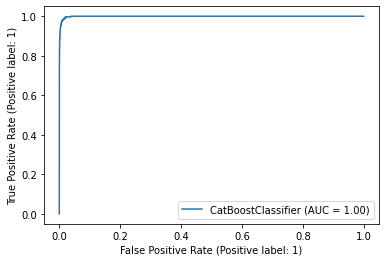

In [19]:
plot_roc_curve(cbt_clf, pool_test, y_test)

In [20]:
y_pred = cbt_clf.predict_proba(pool_test)[:,1]
roc_auc_score(y_test, y_pred)
# ord 0.9752743325974699
# ord scale 0.9756385149177678
# ord pca 0.958221857771802
# ord pca scale 0.9694177580063172
# 0.9990520977728338

0.9990520977728338

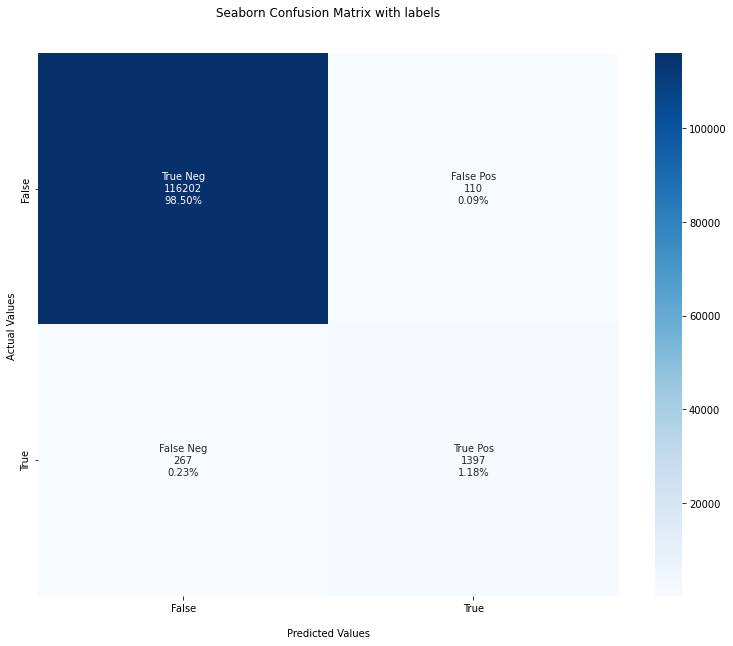

In [21]:
plt.figure(figsize=(13, 10))
group_names = ['True Neg','False Pos','False Neg','True Pos']
cf_matrix = confusion_matrix(y_test,cbt_clf.predict(pool_test))
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

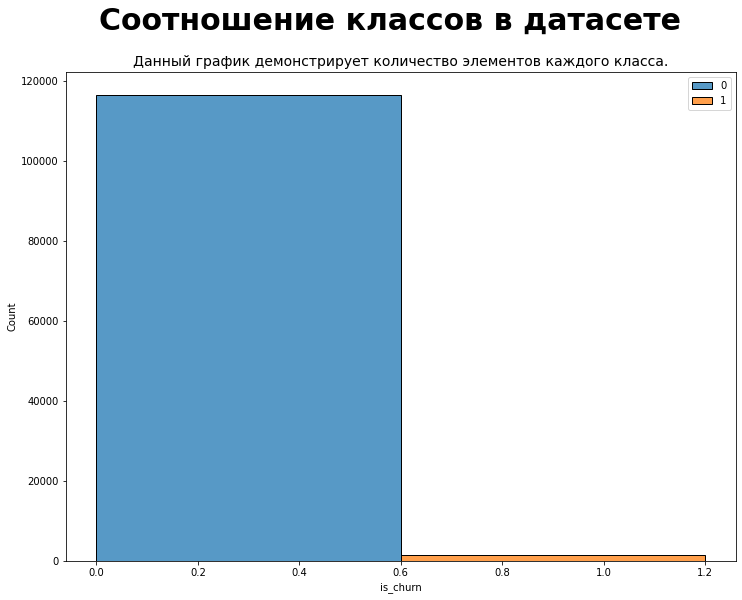

In [22]:
fig = plt.figure(figsize=(12, 9))
sas = sns.histplot(x=y_test, hue=cbt_clf.predict(X_test),multiple="dodge",binwidth=1.2)
fig.suptitle("Соотношение классов в датасете", size = 30, fontweight = 'bold')
plt.title('Данный график демонстрирует количество элементов каждого класса.', fontsize=14)
plt.show()

In [23]:
features_importance = pd.DataFrame({'feature_importance': cbt_clf.get_feature_importance(pool_train), 'feature_names': X_train.columns}).sort_values(by=['feature_importance'], ascending=False)
for index, row in features_importance.iterrows():
    print('{0} : {1}'.format(row['feature_names'], row['feature_importance']))

PRODUCT_NAME=236 : 11.077548626661285
PRODUCT_NAME=174 : 11.066881448618906
PAYMENT_METHOD : 9.632743594546708
PRODUCT_NAME=166 : 9.125592027185949
PRODUCT_NAME=128 : 6.520466141425325
PRODUCT_NAME=64 : 5.170915763291959
PRODUCT_NAME=221 : 3.4977065966295178
PRODUCT_NAME=180 : 3.4218005825295843
PRODUCT_NAME=318 : 3.1413379693098187
PRODUCT_NAME=130 : 2.5479497360604526
PRODUCT_NAME=331 : 2.4887047495410553
PRODUCT_NAME=244 : 2.460020650745137
PRODUCT_NAME=29 : 2.4314213435793577
LANGUAGE : 2.0955626727421373
PLAY_INET : 1.5115229957559813
PRODUCT_NAME=267 : 1.4383702345472404
PRODUCT_NAME=209 : 1.3811208899209657
ADJ_TYP_ACTIVATION_FEES : 1.2063186589357193
REGION : 1.1989694902386154
PRODUCT_NAME=116 : 1.1923714835314392
PLAY_TV : 1.1168949681283753
PRODUCT_NAME=240 : 1.0559606670152049
PRODUCT_NAME=332 : 0.9310392216432233
PLAY_PHONE : 0.7768373854452093
TENURE : 0.7090753070989833
N_NON_SETTLED : 0.6778294061169442
PRODUCT_NAME=44 : 0.6426296915802948
PAY_MON_3 : 0.627880128473454


In [ ]:
# pool_train_all = Pool(train_x, train_y, cat_features=categorical_features)

In [ ]:
# cbt_clf.fit(pool_train_all, logging_level='Verbose', plot=True)
# cbt_clf.save_model('cbt_clf_v2')

In [ ]:
# test_df = pd.read_csv('test_preprocessed.csv', keep_default_na=False)
# test_df

In [ ]:
# test_pool = Pool(test_df, cat_features = categorical_features)
# is_churn = cbt_clf.predict(test_pool)
# is_churn_proba = cbt_clf.predict_proba(test_pool)[:,1]
# print('Соотношение классов: {}'.format(Counter(is_churn)))
# mn, mx = 0, 0
# for el in is_churn_proba:
#     if el < 0.5:
#         mn += 1
#     else:
#         mx += 1
# print('Количество проб меньше 50%: {0}\nКоличество проб больше 50%: {1}'.format(mn, mx))

In [ ]:
# test_data = pd.read_csv('test.csv')
# test_data['is_churn'] = is_churn
# test_data['is_churn_proba'] = is_churn_proba
# test_data

In [ ]:
# test_data.to_csv('test_g2_v4.csv', index=False)

In [ ]:
# t1 = pd.read_csv('test_g2_v3.csv')
# t1_p = list(t1['is_churn_proba'].values)
# t1_c = list(t1['is_churn'].values)
# print(mean_squared_error(t1_p, is_churn_proba))
# print(accuracy_score(t1_c, is_churn))